# DM - Timeseries analysis [TASK 4.1]

Library imports and initial settings.

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pandarallel import pandarallel
import pandas as pd
from tqdm import tqdm_notebook
import zlib
import scipy.stats as stats

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.spatial.distance import pdist, squareform

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import os
import sys
import logging as lg
import warnings

warnings.filterwarnings("ignore")

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

nb_workers = int(os.cpu_count() / 2 + 1)

pandarallel.initialize(
    progress_bar=True,
    nb_workers=nb_workers,
)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Fetching users and tweets dataset saved.

In [2]:
# Load the users and tweets dataset from pickle
dataset = fetch_preprocessed_dataset(step_name="outlier_detection")
users = dataset['users.pickle']
tweets = dataset['tweets.pickle']

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              11508 non-null  int64         
 1   name            11508 non-null  string        
 2   lang            11508 non-null  string        
 3   bot             11508 non-null  bool          
 4   created_at      11508 non-null  datetime64[ns]
 5   statuses_count  11508 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), string(2)
memory usage: 550.7 KB


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10266779 entries, 0 to 13664695
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         object        
 1   retweet_count   float64       
 2   reply_count     float64       
 3   favorite_count  float64       
 4   num_hashtags    float64       
 5   num_urls        float64       
 6   num_mentions    float64       
 7   created_at      datetime64[ns]
 8   text            string        
dtypes: datetime64[ns](1), float64(6), object(1), string(1)
memory usage: 783.3+ MB


## Preprocessing

Remove tweets with invalid `user_id`.

In [5]:
user_ids = set([str(i) for i in users['id'].values.tolist()])

tweets = tweets[tweets['user_id'].map(lambda i: i in user_ids)].astype({'user_id': 'int64'})

Tweets filtering by date. Here are used tweets of year 2019.

In [6]:
INIT_2019_TIMESTAMP = pd.Timestamp('2019-01-01')
INIT_2020_TIMESTAMP = pd.Timestamp('2020-01-01')

mask_tweets_2019 = tweets['created_at'].parallel_map(lambda t: INIT_2019_TIMESTAMP <= t < INIT_2020_TIMESTAMP)
tweets = tweets[mask_tweets_2019]
tweets = tweets.sort_values(by=['created_at'])

tweets

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
8384098,2240858066,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-01 00:21:18,tava me sentindo super mal esses dias
6210422,2240858066,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-01 00:23:50,Ãs vezes tudo o que a gente precisa pra se se...
6852918,2240858066,4.0,0.0,0.0,0.0,0.0,1.0,2019-01-01 00:24:30,RT @myh3ro: TO FAZENDO TODO MUNDO ASSISTIR SHE...
192212,494302461,1.0,0.0,0.0,0.0,0.0,0.0,2019-01-01 00:47:32,"Ã cosÃ¬, mente e cuore sono anarchici nella l..."
7159403,494302461,8.0,0.0,7.0,0.0,0.0,0.0,2019-01-01 00:48:03,"Le cose piÃ¹ belle non sono perfette, sono spe..."
...,...,...,...,...,...,...,...,...,...
7460655,2275740517,1.0,0.0,1.0,0.0,0.0,0.0,2019-11-15 22:02:30,Anche la mia mamma quando ero piccolo mi sgrid...
12234385,2273349732,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-15 22:03:55,LE DIFFICOLTA' SONO COME LA CARTAIGIENICA... N...
9099401,2275248397,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-15 22:05:08,Tra 20 anni sarai deluso per ciÃ² che non hai ...
9440580,2274254095,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-15 22:10:43,"Vuoi sapere chi sei? Non chiedertelo, agisci: ..."


Computation of indexes `acceptance_score` and `diffusion_score` to combine them in the `success_score`.

In [7]:
acceptance_score = tweets['retweet_count'] + tweets['reply_count'] + tweets['favorite_count']
diffusion_score = tweets['num_hashtags'] + tweets['num_mentions'] + tweets['num_urls']

tweets["success_score"] = acceptance_score / (diffusion_score + 0.1)

tweets["success_score"].describe()

count    4.474637e+06
mean     1.337116e+02
std      4.083013e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      9.090909e-01
max      1.823150e+06
Name: success_score, dtype: float64

Useless columns removal.

In [8]:
users = users[["id", "bot"]]
tweets = tweets[["user_id", "success_score", "created_at"]]

Success score timeseries column addition. Here it's created a new column for each users with the list of `success_score` ordered by `created_at` date.

In [9]:
def time_series_by_days(group):
    result = [-1 for _ in range(365)]
    success_score_serie = group.groupby(tweets["created_at"].dt.date)["success_score"].sum()
    for index, success_score in success_score_serie.items():
        result[pd.Period(index, freq='D').day_of_year - 1] = success_score
    return result

tweets_grouped_by_users = tweets.groupby(["user_id"]).parallel_apply(time_series_by_days)

users = users.merge(tweets_grouped_by_users.to_frame("success_score"), left_on='id', right_index=True)

`users` preprocessed dataframe.

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6787 entries, 0 to 11506
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             6787 non-null   int64 
 1   bot            6787 non-null   bool  
 2   success_score  6787 non-null   object
dtypes: bool(1), int64(1), object(1)
memory usage: 165.7+ KB


In [11]:
users

,id,bot,success_score
0,2353593986,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,2358850842,False,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,466124818,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
5,2199062688,False,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9,2357425536,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...
11496,39220893,False,"[-1, -1, 1.8181818181818181, 18.00586510263929..."
11497,2364069194,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11501,2364683192,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11504,1378532629,False,"[-1, -1, 20.0, 0.0, 0.0, 0.0, 161.818181818181..."


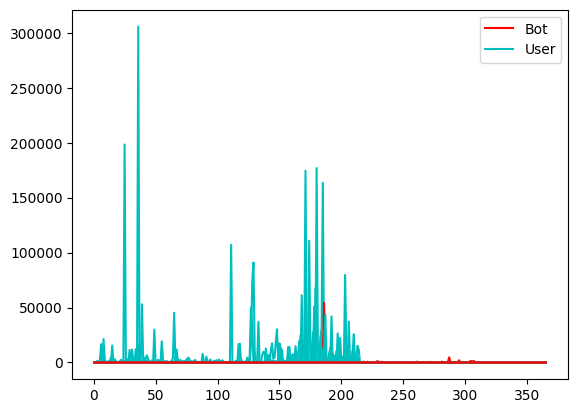

In [143]:
for i, user in list(users.iterrows())[:80]:
    success_score = user["success_score"]
    color = "r" if user["bot"] else "c"
    plt.plot(range(1, len(success_score) + 1), success_score, c=color)

plt.legend(['Bot', 'User'])
plt.show()

In [12]:
# save time series users pickle
store_preprocessed_dataset(step_name="timeseries", file_name="users.pickle", df=users)

In [2]:
# Load the users dataset from pickle
dataset = fetch_preprocessed_dataset(step_name="timeseries")
users = dataset['users.pickle']

## Time series clustering

### KMeans for time series

In [3]:
X = np.array([t for t in users["success_score"].values])

X.shape

(6787, 365)

In [4]:
scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(X)

In [163]:
def gridsearch_plot(create_model, params, x, labels=None, metric_callback=None):
    xvalues = []
    inertias = []
    metric_callback = metric_callback if metric_callback is not None else (lambda m: m.inertia_)
    for i, param in enumerate(tqdm_notebook(params)):
        model = create_model(param)
        model.fit(x)
        metric = metric_callback(model)
        if metric is not None:
            xvalues.append(param["xvalue"] if "xvalue" in param else i)
            inertias.append(metric)
    plt.plot(xvalues, inertias)
    if labels is not None:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    plt.grid(True)
    plt.show()

In [39]:
params_kmeans_ts = [{'k': i, 'xvalue': i} for i in list(range(2, 31))]
def create_kmeans_ts(param):
    return TimeSeriesKMeans(n_clusters=param["k"], metric="euclidean", max_iter=100, n_init=10, n_jobs=-1)

gridsearch_plot(create_kmeans_ts, params_kmeans_ts, X_scaled, ("K", "Euclidean"))

In [40]:
kmeans_ts = create_kmeans_ts({"k": 14})
kmeans_ts.fit(X_scaled)

lg.info(f'Euclidean: {kmeans_ts.inertia_}')

2023-01-05 15:42:22,744 - root - INFO - Euclidean: 1.8173493221398482
2023-01-05 15:42:22,744 - root - INFO - Euclidean: 1.8173493221398482
2023-01-05 15:42:22,744 - root - INFO - Euclidean: 1.8173493221398482


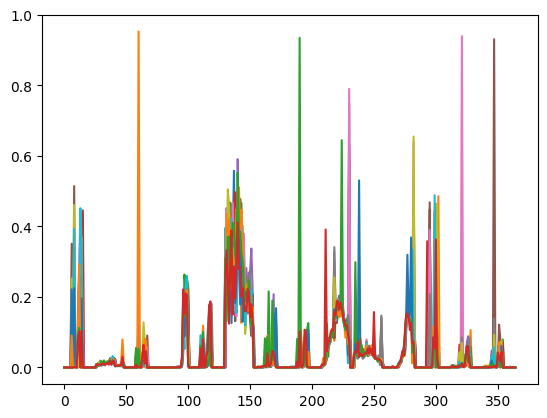

In [41]:
cluster_centers = kmeans_ts.cluster_centers_

plt.plot(cluster_centers.reshape(cluster_centers.shape[1], -1))

plt.show()

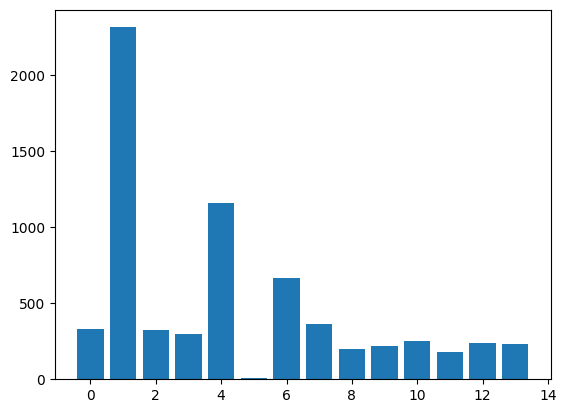

In [56]:
def plot_clusters_distribution(model):
    labels_distribution = np.unique(model.labels_, return_counts=True)
    plt.bar(labels_distribution[0], labels_distribution[1])
    plt.show()

plot_clusters_distribution(kmeans_ts)

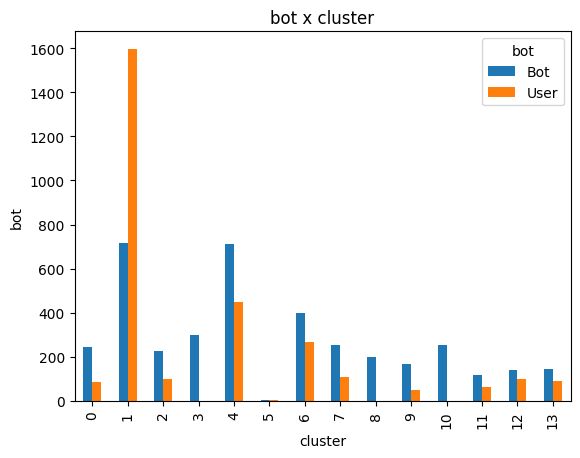

bot    Bot  User
row_0           
0      243    85
1      716  1596
2      225    98
3      297     0
4      711   449
5        6     4
6      400   268
7      255   108
8      201     0
9      169    51
10     253     0
11     116    64
12     140   100
13     143    89


In [60]:
def plot_bot_distribution(model):
    users_pct = pd.crosstab(model.labels_, users['bot'].map(lambda x: 'Bot' if x else 'User'))

    users_pct.plot(kind='bar', stacked=False, title='bot x cluster')
    plt.xlabel('cluster')
    plt.ylabel('bot')
    plt.show()
    print(users_pct)

plot_bot_distribution(kmeans_ts)

### Feature-based clustering

In [182]:
def calculate_features(data):
    return pd.DataFrame.from_records([{
        "mean": np.mean(values),
        "std": np.std(values),
        "variance": np.var(values),
        "median": np.median(values),
        "p10": np.percentile(values, 10),
        "p25": np.percentile(values, 25),
        "p50": np.percentile(values, 50),
        "p75": np.percentile(values, 75),
        "p90": np.percentile(values, 90),
        "iqr": np.percentile(values, 75) - np.percentile(values, 25),
        "covariance": 1.0 * np.mean(values) / np.std(values),
        "skew": stats.skew(values),
        "kurtosis": stats.kurtosis(values)
    } for values in data]).astype(float)

In [183]:
features = calculate_features(X_scaled)

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6787 entries, 0 to 6786
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean        6787 non-null   float64
 1   std         6787 non-null   float64
 2   variance    6787 non-null   float64
 3   median      6787 non-null   float64
 4   p10         6787 non-null   float64
 5   p25         6787 non-null   float64
 6   p50         6787 non-null   float64
 7   p75         6787 non-null   float64
 8   p90         6787 non-null   float64
 9   iqr         6787 non-null   float64
 10  covariance  6787 non-null   float64
 11  skew        6787 non-null   float64
 12  kurtosis    6787 non-null   float64
dtypes: float64(13)
memory usage: 689.4 KB


#### KMeans

  0%|          | 0/29 [00:00<?, ?it/s]

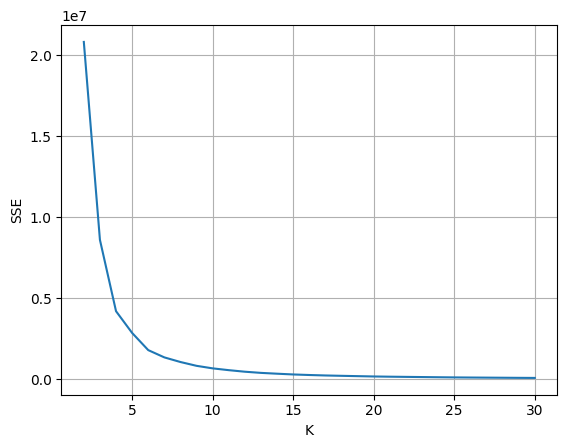

In [125]:
params_kmeans = [{'k': i, 'xvalue': i} for i in list(range(2, 31))]
def create_kmeans(param):
    return KMeans(n_clusters=param["k"], max_iter=100, n_init=10)

gridsearch_plot(create_kmeans, params_kmeans, features, ("K", "SSE"))

In [208]:
kmeans = create_kmeans({"k": 6})
kmeans.fit(features)

lg.info(f'SSE: {kmeans_ts.inertia_}')

2023-01-05 18:03:13,051 - root - INFO - SSE: 1.8173493221398482
2023-01-05 18:03:13,051 - root - INFO - SSE: 1.8173493221398482
2023-01-05 18:03:13,051 - root - INFO - SSE: 1.8173493221398482


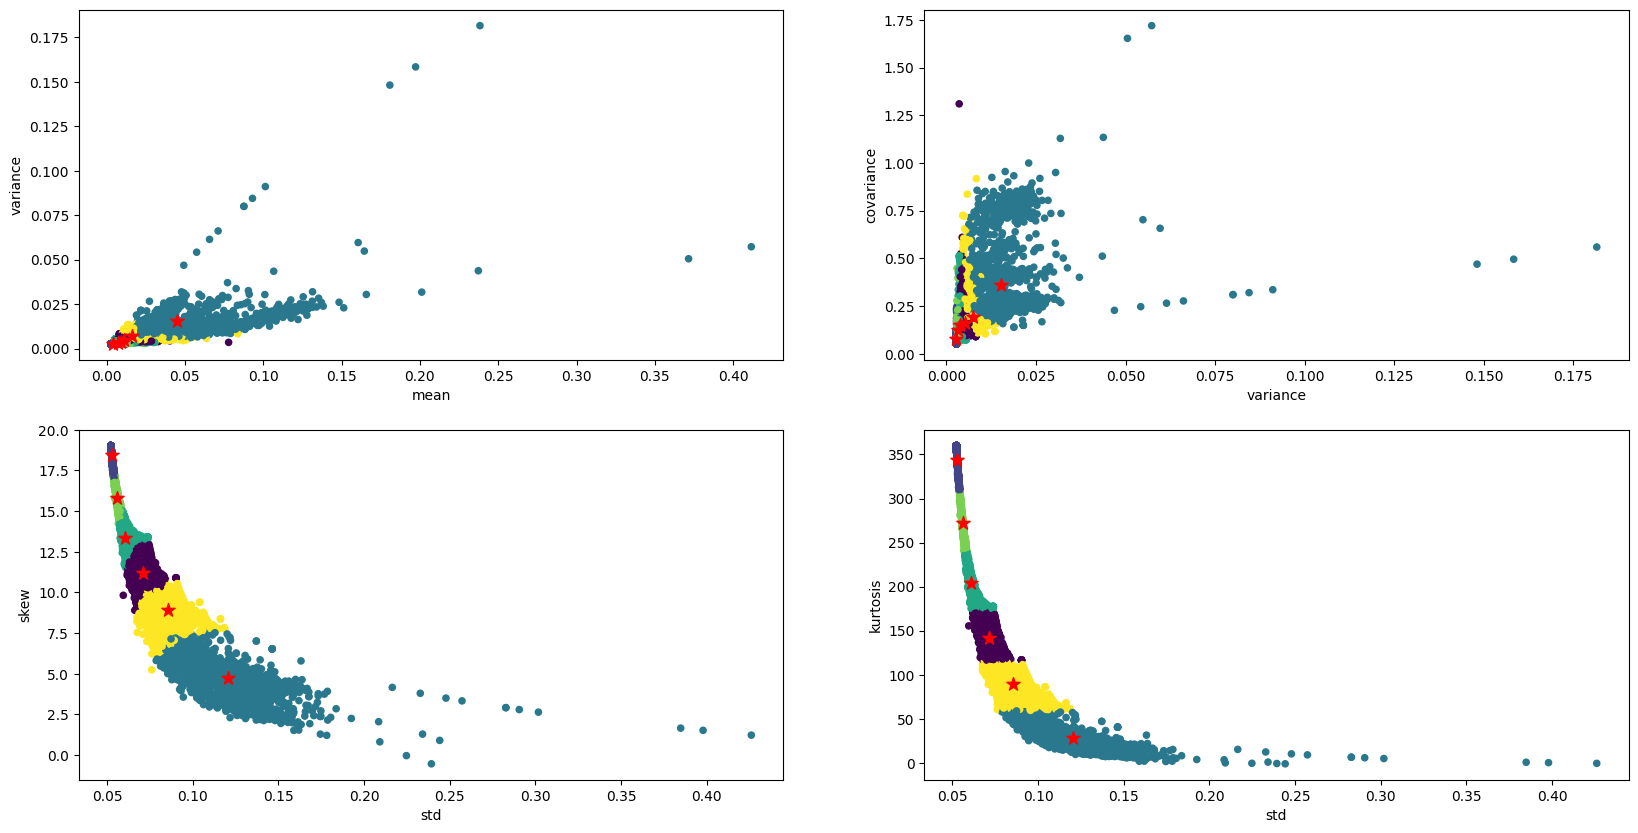

In [219]:
scatter_plt_pairs = [
    (0, 2),
    (2, 10),
    (1, 11),
    (1, 12)
]

configs = [
    {
        'type': 'scatter',
        'df': features,
        'labels': kmeans.labels_,
        'centers': kmeans.cluster_centers_,
        'x_index': x_index,
        'y_index': y_index,
    } for x_index, y_index in scatter_plt_pairs
]

build_grid_plot(configs=configs)

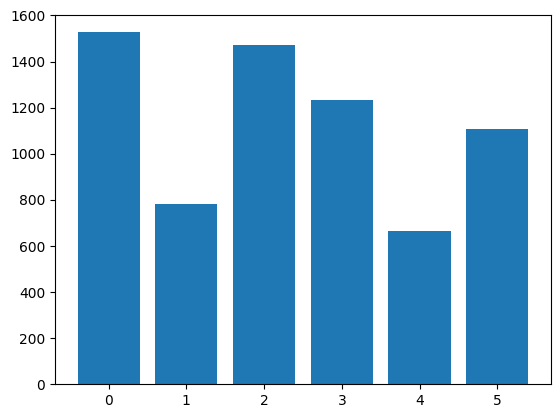

In [128]:
plot_clusters_distribution(kmeans)

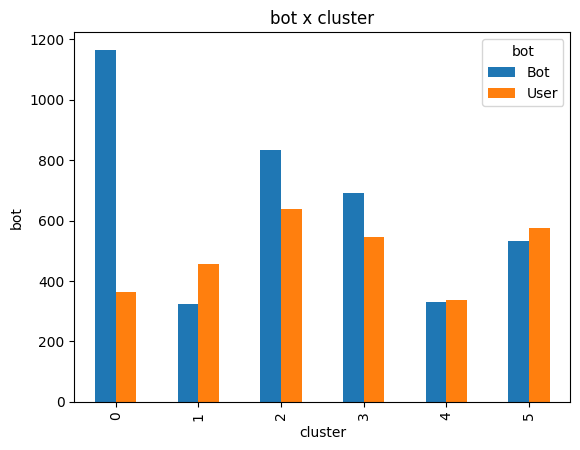

bot     Bot  User
row_0            
0      1165   362
1       325   456
2       834   637
3       690   544
4       330   337
5       531   576


In [129]:
plot_bot_distribution(kmeans)

#### DBScan

  0%|          | 0/8 [00:00<?, ?it/s]

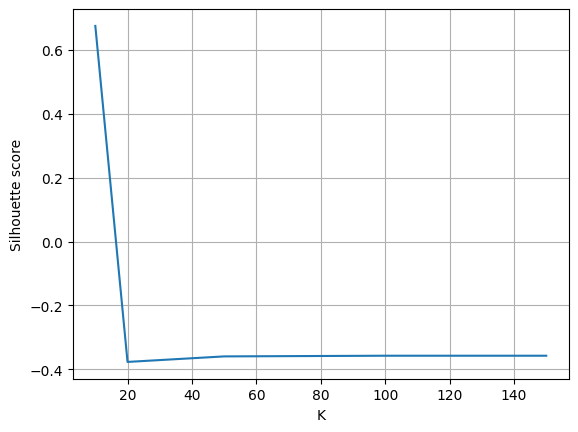

In [207]:
params_dbscan = [{'k': i, 'xvalue': i} for i in [10, 20, 50, 100, 150, 200, 500, 1000]]
def create_dbscan(param):
    return DBSCAN(eps=0.1, min_samples=param["k"])

def metric_callback(model):
    # check if there are at least 2 different values
    if len(set(model.labels_)) >= 2:
        # negative metric
        return - silhouette_score(features, model.labels_)

gridsearch_plot(create_dbscan, params_dbscan, features, ("K", "Silhouette score"), metric_callback=metric_callback)

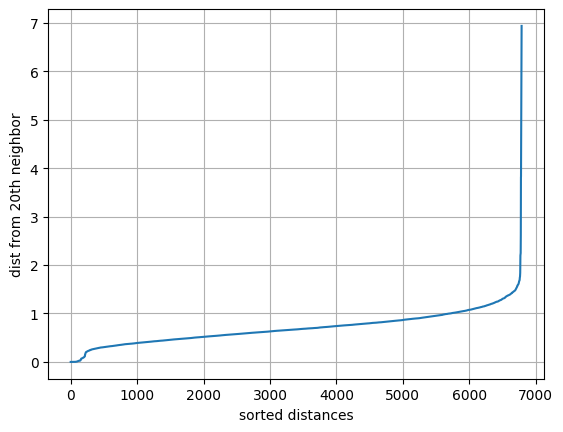

In [221]:
def plot_knee_method(df, k):
    dist = squareform(pdist(df, 'euclidean'))
    kth_distances = [d[np.argsort(d)[k]] for d in dist]
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel(f'dist from {k}th neighbor')
    plt.xlabel('sorted distances')
    plt.grid(True)
    plt.show()

plot_knee_method(features, 20)

In [209]:
dbscan = DBSCAN(eps=1.5, min_samples=k)
dbscan.fit(features)

lg.info(f'Silhouette {silhouette_score(features, dbscan.labels_)}')

2023-01-05 18:04:19,827 - root - INFO - Silhouette 0.09334257528054704
2023-01-05 18:04:19,827 - root - INFO - Silhouette 0.09334257528054704
2023-01-05 18:04:19,827 - root - INFO - Silhouette 0.09334257528054704


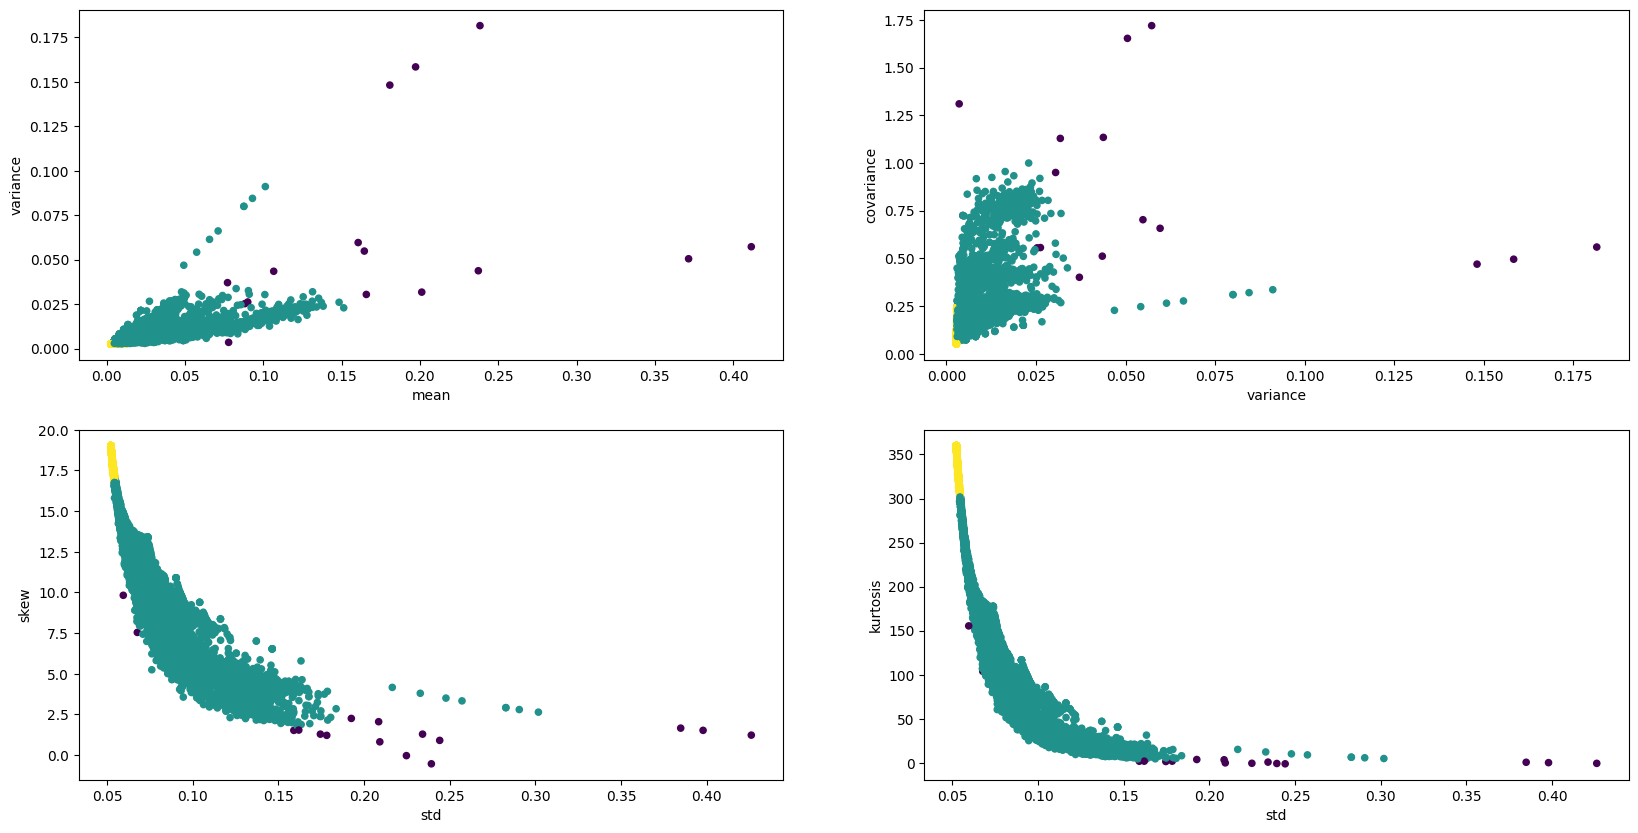

In [220]:
configs = [
    {
        'type': 'scatter',
        'df': features,
        'labels': dbscan.labels_,
        'x_index': x_index,
        'y_index': y_index,
    } for x_index, y_index in scatter_plt_pairs
]

build_grid_plot(configs=configs)

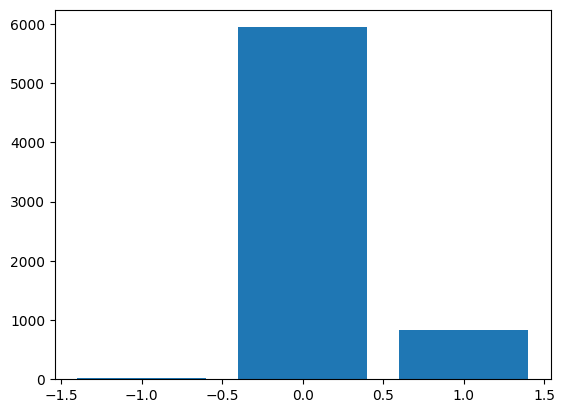

In [213]:
plot_clusters_distribution(dbscan)

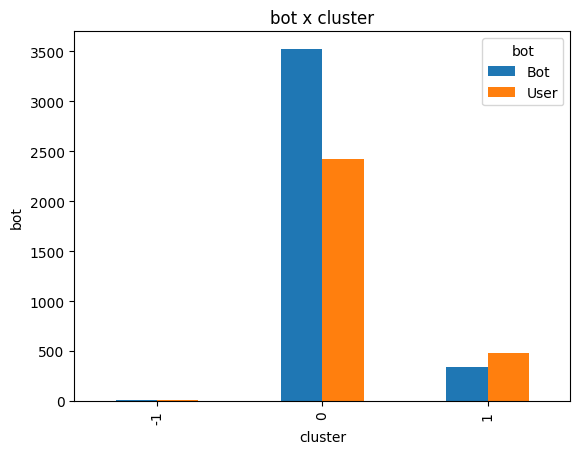

bot     Bot  User
row_0            
-1        9     7
 0     3523  2422
 1      343   483


In [212]:
plot_bot_distribution(dbscan)

### Compression-based clustering

In [ ]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

CDM = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

## Shapelets discovery